## Import libraries 

In [243]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from photutils.datasets import make_100gaussians_image
from photutils.background import Background2D, MedianBackground
from photutils.aperture import CircularAnnulus, CircularAperture

## Load data

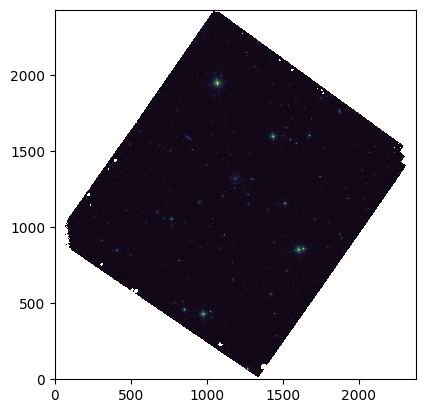

In [244]:
data, header = fits.getdata('DESIJ1624+0129_F140W_drz_sci.fits', header=True)

plt.imshow(np.log10(data), origin='lower',
           cmap='cubehelix', interpolation='nearest')

## Background estimation

C:\Users\ahmad\AppData\Local\Temp\ipykernel_33564\3750751740.py:6: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(data - bkg.background), origin='lower',


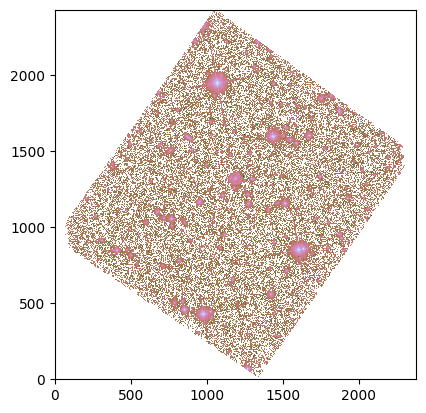

In [245]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

plt.imshow(np.log10(data - bkg.background), origin='lower',
           cmap='cubehelix', interpolation='nearest')

## Aperture photometry

In [246]:
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from photutils.segmentation import SourceFinder
from photutils.segmentation import SourceCatalog

np.median(bkg.background), np.median(bkg.background_rms)
bkg_subtracted_data = data - bkg.background
threshold = 2 * bkg.background_rms


segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

segm_deblend = deblend_sources(bkg_subtracted_data, segment_map,
                               npixels=10, nlevels=32, contrast=0.001,
                               progress_bar=False)

finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)
print(segment_map.nlabels)

cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)

<photutils.segmentation.core.SegmentationImage>
shape: (2432, 2379)
nlabels: 1400
labels: [   1    2    3    4    5 ... 1396 1397 1398 1399 1400]
1400
<photutils.segmentation.catalog.SourceCatalog>
Length: 1400
labels: [   1    2    3    4    5 ... 1396 1397 1398 1399 1400]


C:\Users\ahmad\AppData\Local\Temp\ipykernel_33564\1248473156.py:4: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(data- bkg.background), origin='lower', cmap='cubehelix', vmin= -4, vmax= 2)


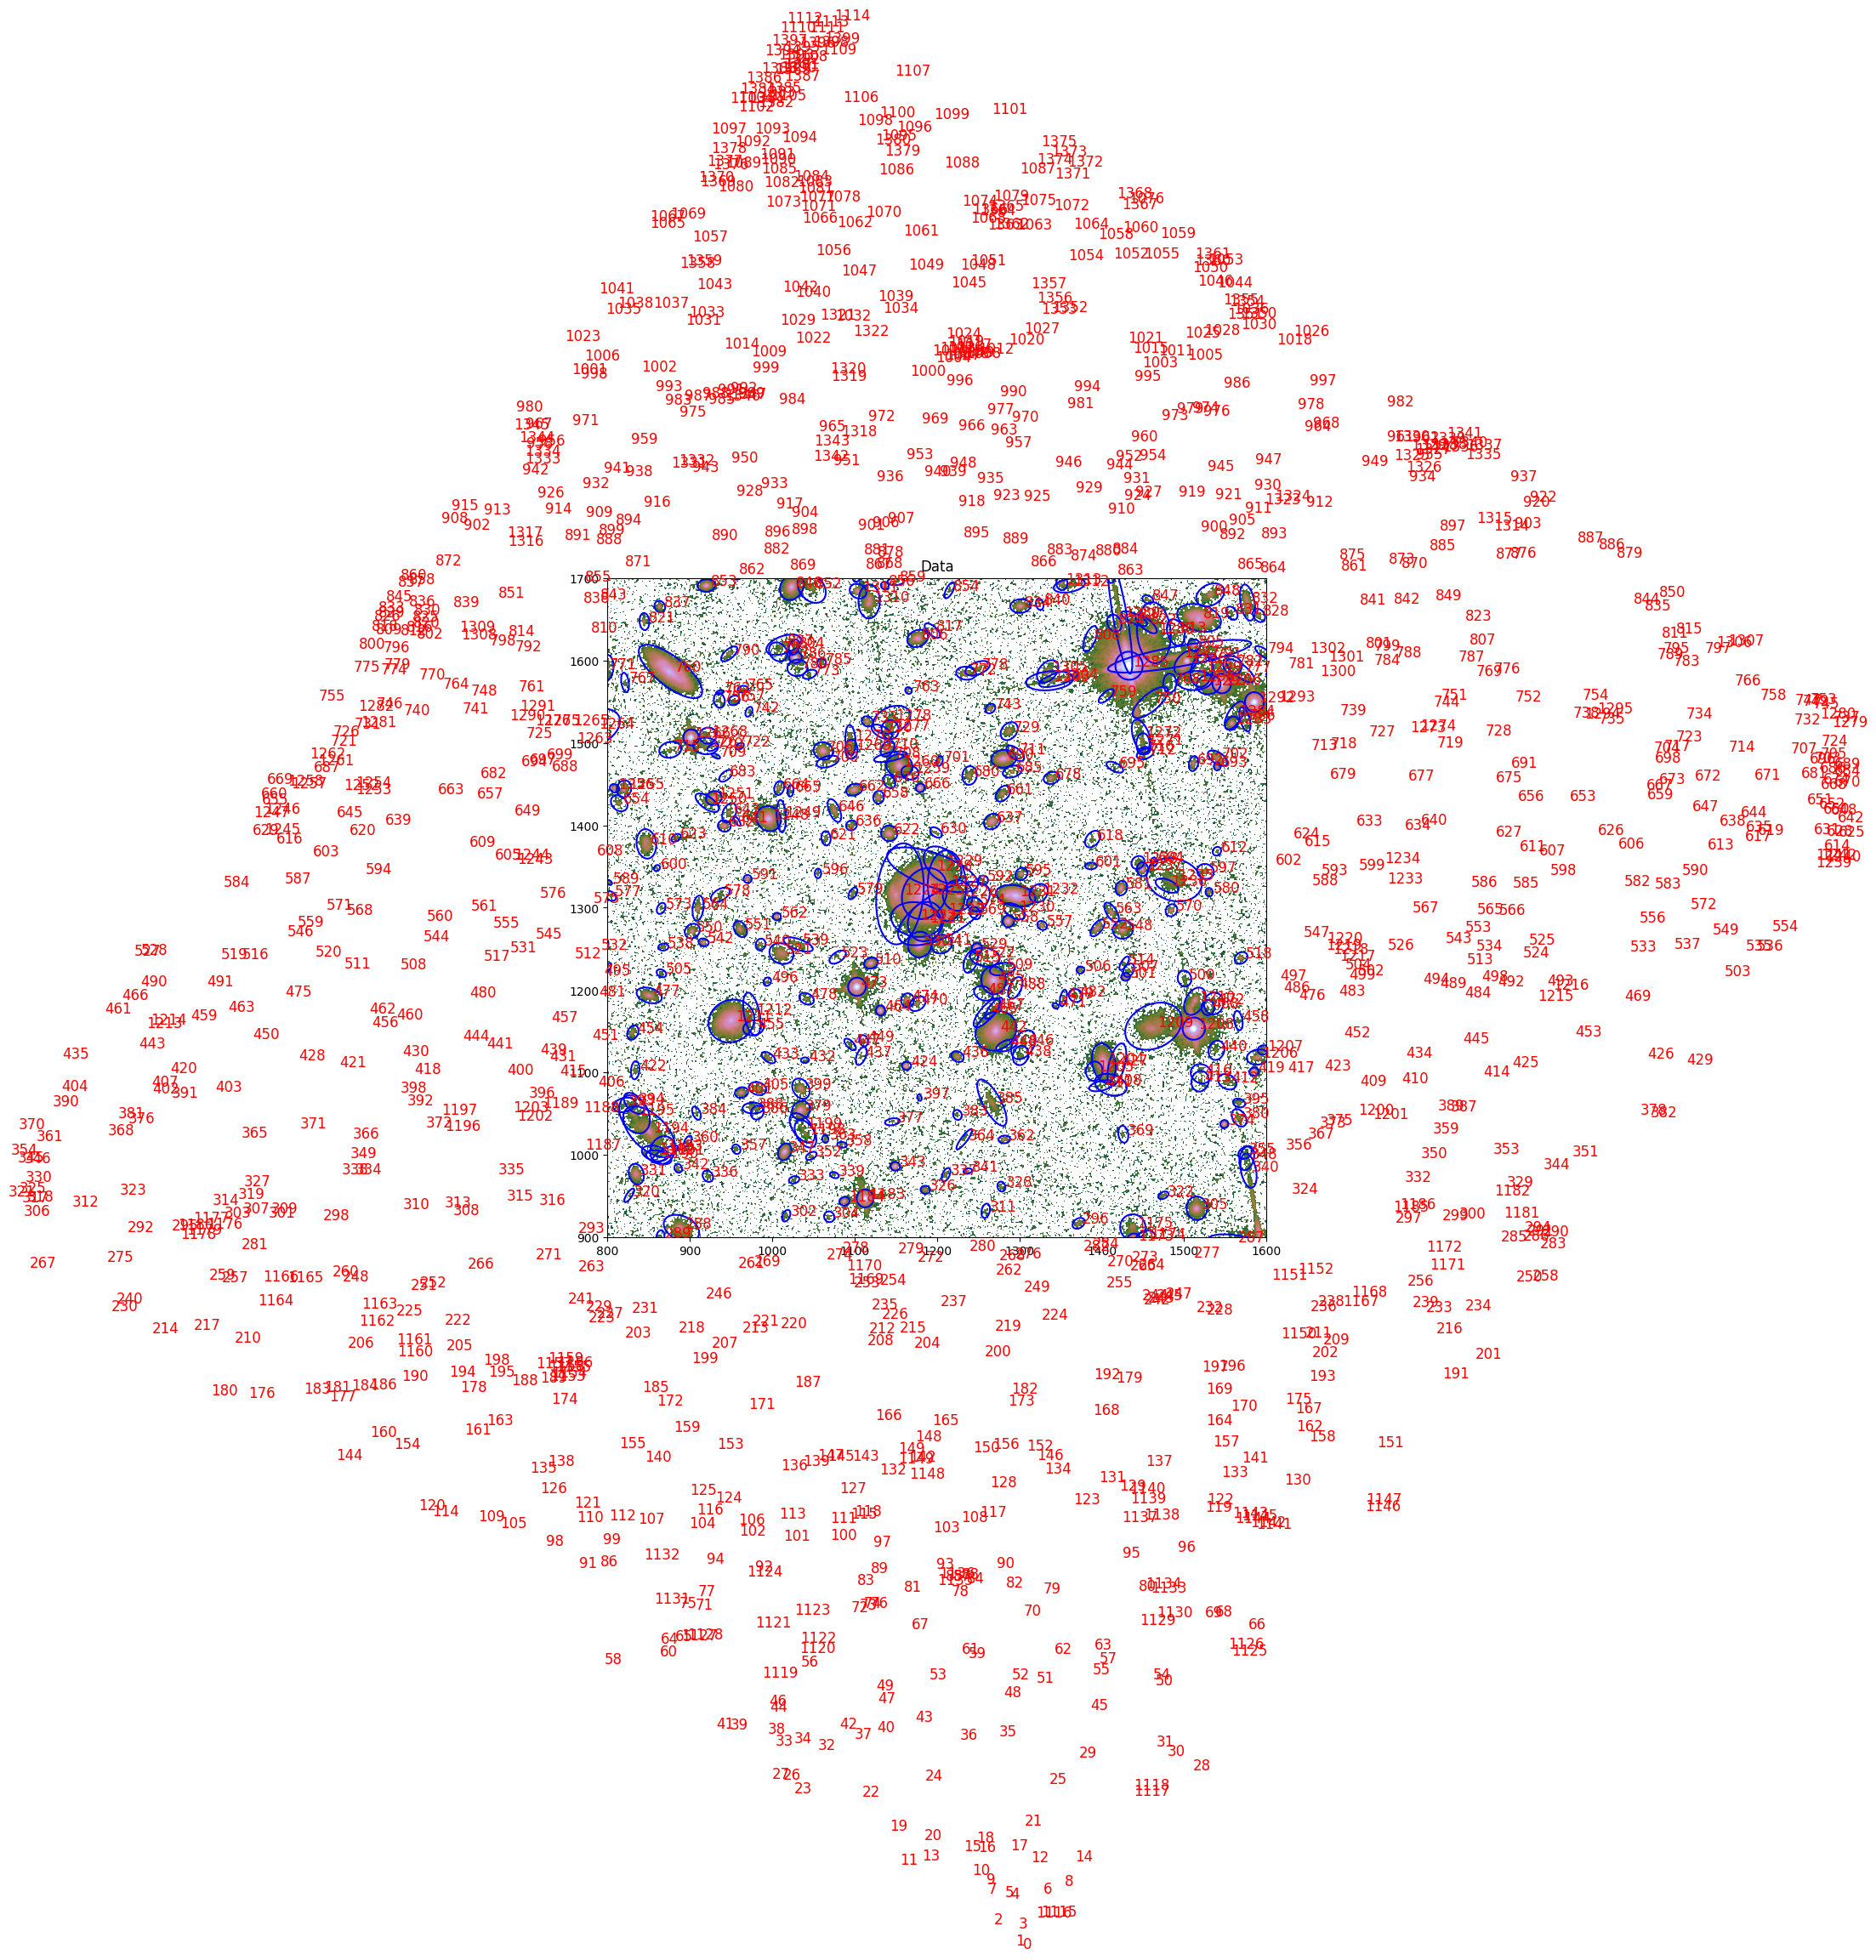

In [247]:
norm = simple_norm(data, 'sqrt')

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(np.log10(data- bkg.background), origin='lower', cmap='cubehelix', vmin= -4, vmax= 2)
ax1.set_title('Data')

cat.plot_kron_apertures(ax=ax1, color='blue', lw=1.5);

for i in range(len(cat)):
    ax1.text(cat.xcentroid[i]+5, cat.ycentroid[i],
             f'{i}', c='r', fontsize=12
             #transform=ax1.transAxes
             )
# cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5);

ax1.set_xlim(800, 1600)
ax1.set_ylim(900, 1700)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

### Close Galaxies, Distance, Flux

In [248]:
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['kron_flux'].info.format = '.2f'

In [249]:
# close galaxies
id_central = 1225 # object id of your central deflector lens
highest_id = segment_map.nlabels

x0 = tbl['xcentroid'].value[id_central]
y0 = tbl['ycentroid'].value[id_central]
f0 = tbl['kron_flux'].value[id_central]

close_galaxies = []
dist_galaxies = []
flux_galaxies = []
close_galaxies_1_percent_flux = []
dist_galaxies_1_percent_flux = []
flux_galaxies_1_percent_flux = []

for i in range(len(tbl)):
    if i == highest_id:
        continue
    x = tbl['xcentroid'].value[i]
    y = tbl['ycentroid'].value[i]
    f = tbl['kron_flux'].value[i]
    if (np.sqrt((x-x0)**2 + (y-y0)**2) < 20/0.08):
        close_galaxies.append(i)
        flux_galaxies.append(f)
        dist_galaxies.append(np.sqrt((x-x0)**2 + (y-y0)**2))
    if (np.sqrt((x-x0)**2 + (y-y0)**2) < 20/0.08) & (f > f0*0.01):
        close_galaxies_1_percent_flux.append(i)
        flux_galaxies_1_percent_flux.append(f)
        dist_galaxies_1_percent_flux.append(np.sqrt((x-x0)**2 + (y-y0)**2))

print("Close galaxies:", (close_galaxies))
print("Close galaxies_1_percent_flux:", (close_galaxies_1_percent_flux))

Close galaxies: [397, 424, 432, 436, 437, 438, 442, 446, 447, 448, 449, 464, 465, 467, 470, 471, 473, 474, 478, 479, 482, 485, 487, 488, 496, 506, 509, 510, 515, 521, 522, 523, 529, 530, 539, 540, 541, 548, 551, 552, 557, 558, 562, 563, 569, 574, 578, 579, 581, 591, 592, 595, 596, 601, 618, 621, 622, 630, 636, 637, 641, 646, 658, 661, 662, 664, 665, 666, 676, 678, 680, 685, 690, 700, 701, 706, 708, 710, 711, 729, 730, 733, 743, 763, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1248, 1249, 1259, 1260, 1269, 1270, 1277, 1278]
Close galaxies_1_percent_flux: [424, 436, 442, 464, 473, 474, 485, 510, 521, 529, 530, 539, 541, 548, 551, 552, 558, 562, 563, 574, 581, 595, 622, 637, 646, 658, 661, 662, 666, 678, 690, 706, 710, 729, 733, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1231, 1248, 1260, 1270, 1277, 1278]


### pixel to arcsec

In [250]:
from astropy.wcs import WCS

def distance_arcsec(x):
    wcs = WCS(header)

    pixel_distance = x

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

### Data frame for close galaxies with and without applying 1% flux filter

In [251]:
import pandas as pd

n_sys = 7  #number of galaxies detected inside your lensing system

df = pd.DataFrame({'Distance(pixels)': dist_galaxies})
df_1_percent_flux = pd.DataFrame({'Distance(pixels)': dist_galaxies_1_percent_flux})

df.set_index(pd.Index(close_galaxies), inplace=True)
df_1_percent_flux.set_index(pd.Index(close_galaxies_1_percent_flux), inplace=True)

df['Distance(arcsec)'] = distance_arcsec(df['Distance(pixels)'])
df['Flux'] = flux_galaxies
df_1_percent_flux['Distance(arcsec)'] = distance_arcsec(df_1_percent_flux['Distance(pixels)'])
df_1_percent_flux['Flux'] = flux_galaxies_1_percent_flux

# Sort the DataFrame based on 'Distance'
df_sorted = df.sort_values(by='Distance(pixels)')
df_1_percent_flux_sorted = df_1_percent_flux.sort_values(by='Distance(pixels)')

# Exclude the lensing system members
df_sys_removed = df_sorted.iloc[n_sys:]
df_1_percent_flux_sys_removed = df_1_percent_flux_sorted.iloc[n_sys:]

#first 20 galaxies
df_20 = df_sys_removed.iloc[:20]
df_1_percent_flux_20 = df_1_percent_flux_sys_removed.iloc[:20]

print(df_20)
print(df_1_percent_flux_20)

      Distance(pixels)  Distance(arcsec)        Flux
1226         40.329722          3.226378   40.582151
1229         41.069364          3.285549   46.569070
530          62.213179          4.977054  139.214737
574          62.521951          5.001756   18.619827
541          64.793389          5.183471   14.211783
569          65.781104          5.262488    2.246889
592          72.763038          5.821043    0.938007
630          75.445508          6.035641    1.730046
622          84.762414          6.780993   32.514388
579          87.096130          6.967690    2.157284
529          92.043741          7.363499   87.641050
515          99.631745          7.970540    3.484394
522         106.178691          8.494295    5.589695
510         106.697629          8.535810   32.797894
558         107.169795          8.573584   47.706062
1231        110.717299          8.857384  412.370649
1230        111.146880          8.891750    4.046563
637         119.773435          9.581875   27.

### R_10, R_20, sigma_10 and sigma_20 Without filtering 1% flux

In [256]:
R_10 = df_20.iloc[9, df.columns.get_loc('Distance(arcsec)')]
R_20 = df_20.iloc[19, df.columns.get_loc('Distance(arcsec)')]
Sigma_10 = 10/(np.pi*R_10**2)
Sigma_20=20/(np.pi*R_20**2)

%store R_10
%store R_20
%store Sigma_10
%store Sigma_20

print("R 10:", R_10)
print("R 20:", R_20)
print("Sigma 10:", Sigma_10)
print("Sigma 20:", Sigma_20)

Stored 'R_10' (float64)
Stored 'R_20' (float64)
Stored 'Sigma_10' (float64)
Stored 'Sigma_20' (float64)
R 10: 6.967690436394366
R 20: 9.712662233704298
Sigma 10: 0.065565055398911
Sigma 20: 0.067484424856083


### R_10, R_20, sigma_10 and sigma_20 With filtering 1% flux

In [257]:
R_10_1_percent_flux = df_1_percent_flux_20.iloc[9, df_1_percent_flux.columns.get_loc('Distance(arcsec)')]
R_20_1_percent_flux = df_1_percent_flux_20.iloc[19, df_1_percent_flux.columns.get_loc('Distance(arcsec)')]
Sigma_10_1_percent_flux = 10/(np.pi*R_10_1_percent_flux**2)
Sigma_20_1_percent_flux = 20/(np.pi*R_20_1_percent_flux**2)

%store R_10_1_percent_flux
%store R_20_1_percent_flux
%store Sigma_10_1_percent_flux
%store Sigma_20_1_percent_flux

print("R 10_1_percent_flux:", R_10_1_percent_flux)
print("R 20_1_percent_flux:", R_20_1_percent_flux)
print("Sigma 10_1_percent_flux:", Sigma_10_1_percent_flux)
print("Sigma 20_1_percent_flux:", Sigma_20_1_percent_flux)

Stored 'R_10_1_percent_flux' (float64)
Stored 'R_20_1_percent_flux' (float64)
Stored 'Sigma_10_1_percent_flux' (float64)
Stored 'Sigma_20_1_percent_flux' (float64)
R 10_1_percent_flux: 8.857383937295491
R 20_1_percent_flux: 12.175362976659171
Sigma 10_1_percent_flux: 0.040573192993401855
Sigma 20_1_percent_flux: 0.04294536399752746


### Closest 20 galaxies Without filtering 1% flux

[1226, 1229, 530, 574, 541, 569, 592, 630, 622, 579, 529, 515, 522, 510, 558, 1231, 1230, 637, 595, 636]


(900.0, 1700.0)

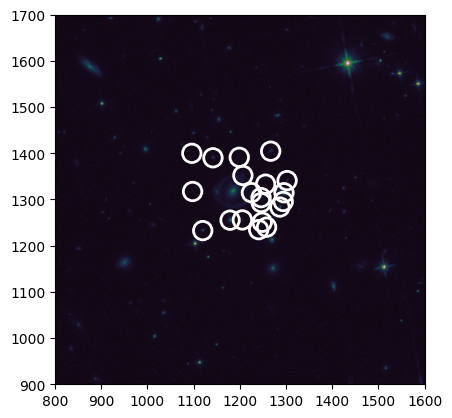

In [254]:
galaxies_20 = df_20.index.tolist()

print(galaxies_20)

positions = [(cat.xcentroid[i], cat.ycentroid[i]) for i in galaxies_20]

aperture = CircularAperture(positions, r=20.0)

plt.imshow(np.log10(data), interpolation='nearest', origin='lower', cmap='cubehelix')

ap_patches = aperture.plot(color='white', lw=2,
                           label='Photometry aperture')

handles = (ap_patches[0])

plt.xlim(800, 1600)
plt.ylim(900, 1700)

### Closest 20 galaxies With filtering 1% flux

[1226, 1229, 530, 574, 541, 622, 529, 510, 558, 1231, 637, 595, 666, 658, 474, 485, 473, 646, 464, 662]


(900.0, 1700.0)

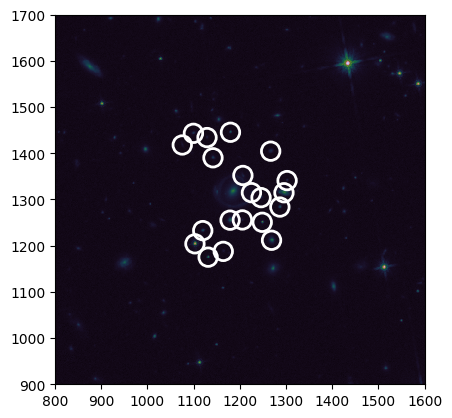

In [255]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from photutils.aperture import CircularAnnulus, CircularAperture
from photutils.datasets import make_100gaussians_image
from photutils.aperture import CircularAnnulus, CircularAperture

galaxies_1_percent_flux_20 = df_1_percent_flux_20.index.tolist()

print(galaxies_1_percent_flux_20)

positions = [(cat.xcentroid[i], cat.ycentroid[i]) for i in galaxies_1_percent_flux_20]

aperture = CircularAperture(positions, r=20.0)

plt.imshow(np.log10(data), interpolation='nearest', origin='lower', cmap='cubehelix')

ap_patches = aperture.plot(color='white', lw=2,
                           label='Photometry aperture')

handles = (ap_patches[0])

plt.xlim(800, 1600)
plt.ylim(900, 1700)